# Economical Cycle Timing

## Import libraries

In [120]:
#Data analysis
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

#Additional functionalities
from IPython.display import display

#Custom python modules
import config

## Read the data

In [7]:
#Read the data
df_xl = pd.read_excel(config.excel_file)

#Show top rows
display(df_xl.head())

,date,value
0,1969-12-31,100.000
1,1970-01-30,94.249
2,1970-02-27,96.979
3,1970-03-31,97.075
4,1970-04-30,87.800


## Data transformations

In [17]:
#df_tf = Data Frame TransFormed
df_tf = df_xl.copy()

#Year column
df_tf['year'] = df_tf['date'].dt.year

#Month column
df_tf['month'] = df_tf['date'].dt.month

#Show top rows
display(df_tf.head())

,date,value,year,month
0,1969-12-31,100.000,1969,12
1,1970-01-30,94.249,1970,1
2,1970-02-27,96.979,1970,2
3,1970-03-31,97.075,1970,3
4,1970-04-30,87.800,1970,4


## Plot the data

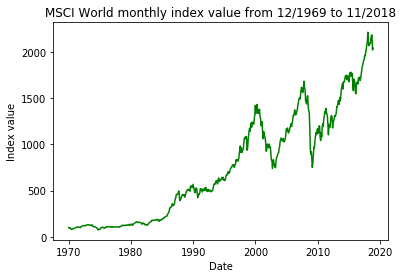

In [18]:
plt.plot(df_tf["date"], df_tf["value"], color="green")
plt.title("MSCI World monthly index value from 12/1969 to 11/2018")
plt.ylabel("Index value")
plt.xlabel("Date")
plt.show()

## Define the parameters

In [101]:
#Select the time windows for the investment
time_windows = [5, 10, 15]

#First year of the simulations
first_year = 1997

#The last year of the simulation
last_year = 2009

#Create a range from the first and the last years
years = range(first_year, last_year + 1)

#The month when investment starts each year
month = 1

#Create a month range to loop each year
months = range(1, 13)

## The simulation

### Functions to parse KPIs from the data frame

In [199]:
#KPI numbers for boughts shares
def kpi_buy(df_arg, y, tw):
        
        df = df_arg.copy()
  
        #Date when buying starts
        b_start = np.datetime64('{}-01-01'.format(y))
        #Date when buying stops
        b_stop = np.datetime64('{}-01-01'.format(y+tw)) - np.timedelta64(1, 'D')
        
        #Get the data frame slice for this starting point and time window
        df_b = df[(df['date']>=b_start) & (df['date']<=b_stop)]
        
        #Sum of purchases
        value_sum = df_b['value'].sum()
        #Number of purchases
        value_n = df_b.shape[0]
        #Average of purchases
        value_mean = df_b['value'].mean()
        
        return (value_sum, value_n, value_mean)
    
#KPI numbers for sold shares
def kpi_sell(df_arg, y, tw):
        
        df = df_arg.copy()
  
        #Date when buying starts
        s_start = np.datetime64('{}-01-01'.format(y+tw))
        
        #Date when selling stops
        #tw_y = int(tw/12)
        #tw_m = tw % 12      
        #stop_m = str(tw_m + 1).zfill(2)
        #stop_y = y + tw + tw_y        
        s_stop = np.datetime64('{}-01-01'.format(y + tw + 1)) - np.timedelta64(1, 'D')
        
        #Get the data frame slice for this starting point and time window
        df_s = df[(df['date']>=s_start) & (df['date']<=s_stop)]
        
        #Sum of purchases
        value_sum = df_s['value'].sum()
        #Number of purchases
        value_n = df_s.shape[0]
        #Average of purchases
        value_mean = df_s['value'].mean()
        
        return (value_sum, value_n, value_mean)
    
#Calculate annual profit expecting cumulative growth
def get_cum_profit(profit, tw):
    
    #When buing shares have been owned half of the buying + selling time
    #Selling time in months equals buying time in years
    owned_y = (tw + tw/12) / 2
    
    cum_profit = (profit + 1) ** (1/(owned_y)) - 1
    
    return cum_profit

### Simulation

In [201]:
results = []

#Loop each starting year
for y in years:    
    #print("Year: {}".format(y))
    
    #Loop each time window
    for tw in time_windows:
        #print("Time window: {} years".format(tw))
        
        #KPIs for bought shares
        b_sum, b_n, b_mean = kpi_buy(df_tf, y, tw)
        
        #KPIs for sold shares
        s_sum, s_n, s_mean = kpi_sell(df_tf, y, tw)
        
        #Print results
        #print("  Mean purcase value: {}".format(b_mean))
        #print("  Mean sell value: {}".format(s_mean))
        
        #Profit KPIs
        profit = (s_mean / b_mean) - 1
        profit_cum = get_cum_profit(profit, tw)
        
        r = {
            "start_year": y,
            "time_window": tw,
            "mean_buy": np.round(b_mean, 1),
            "mean_sell": np.round(s_mean, 1),
            "profit_prct": np.round(profit * 100, 2),
            "profit_prct_cum": np.round(profit_cum * 100, 2), 
        }
        
        results.append(r)
        
df_results = pd.DataFrame(results)

#Show top rows
display(df_results.head())

,mean_buy,mean_sell,profit_prct,profit_prct_cum,start_year,time_window
0,1114.5,883.3,-20.75,-8.23,1997,5
1,1094.4,1578.8,44.26,7.00,1997,10
2,1148.7,1279.6,11.40,1.34,1997,15
3,1111.1,874.1,-21.34,-8.48,1998,5
4,1162.2,1288.4,10.86,1.92,1998,10


## Analyze results

### By investing year

In [202]:
for y in years:
    df_y = df_results[df_results['start_year']==y]
    display(df_y)

,mean_buy,mean_sell,profit_prct,profit_prct_cum,start_year,time_window
0,1114.5,883.3,-20.75,-8.23,1997,5
1,1094.4,1578.8,44.26,7.00,1997,10
2,1148.7,1279.6,11.40,1.34,1997,15


,mean_buy,mean_sell,profit_prct,profit_prct_cum,start_year,time_window
3,1111.1,874.1,-21.34,-8.48,1998,5
4,1162.2,1288.4,10.86,1.92,1998,10
5,1174.0,1503.6,28.08,3.09,1998,15


,mean_buy,mean_sell,profit_prct,profit_prct_cum,start_year,time_window
6,1077.0,1066.2,-1.00,-0.37,1999,5
7,1186.6,991.9,-16.41,-3.25,1999,10
8,1204.6,1701.1,41.22,4.34,1999,15


,mean_buy,mean_sell,profit_prct,profit_prct_cum,start_year,time_window
9,1042.5,1181.1,13.30,4.72,2000,5
10,1161.9,1154.5,-0.64,-0.12,2000,10
11,1235.4,1711.7,38.56,4.10,2000,15


,mean_buy,mean_sell,profit_prct,profit_prct_cum,start_year,time_window
12,1013.4,1366.2,34.82,11.66,2001,5
13,1144.6,1272.9,11.21,1.98,2001,10
14,1261.0,1673.1,32.68,3.54,2001,15


,mean_buy,mean_sell,profit_prct,profit_prct_cum,start_year,time_window
15,1074.2,1578.8,46.97,15.28,2002,5
16,1165.7,1279.6,9.77,1.74,2002,10
17,1301.8,1944.2,49.35,5.06,2002,15


,mean_buy,mean_sell,profit_prct,profit_prct_cum,start_year,time_window
18,1213.3,1288.4,6.19,2.24,2003,5
19,1205.4,1503.6,24.74,4.17,2003,10
20,1372.5,2113.0,53.95,5.45,2003,15


,mean_buy,mean_sell,profit_prct,profit_prct_cum,start_year,time_window
21,1296.1,991.9,-23.47,-9.41,2004,5
22,1268.3,1701.1,34.12,5.57,2004,10
23,1451.4,NaN,NaN,NaN,2004,15


,mean_buy,mean_sell,profit_prct,profit_prct_cum,start_year,time_window
24,1281.3,1154.5,-9.90,-3.77,2005,5
25,1331.8,1711.7,28.52,4.74,2005,10
26,1479.1,NaN,NaN,NaN,2005,15


,mean_buy,mean_sell,profit_prct,profit_prct_cum,start_year,time_window
27,1275.9,1272.9,-0.24,-0.09,2006,5
28,1384.9,1673.1,20.81,3.55,2006,10
29,1502.2,NaN,NaN,NaN,2006,15


,mean_buy,mean_sell,profit_prct,profit_prct_cum,start_year,time_window
30,1257.3,1279.6,1.78,0.65,2007,5
31,1415.6,1944.2,37.34,6.03,2007,10
32,1513.6,NaN,NaN,NaN,2007,15


,mean_buy,mean_sell,profit_prct,profit_prct_cum,start_year,time_window
33,1197.5,1503.6,25.57,8.77,2008,5
34,1452.1,2113.0,45.51,7.17,2008,10
35,1507.6,NaN,NaN,NaN,2008,15


,mean_buy,mean_sell,profit_prct,profit_prct_cum,start_year,time_window
36,1240.5,1701.1,37.13,12.36,2009,5
37,1529.7,NaN,NaN,NaN,2009,10
38,1529.7,NaN,NaN,NaN,2009,15


### By time window

In [108]:
for tw in time_windows:
    df_tw = df_results[df_results['time_window']==tw]
    display(df_tw)

,mean_buy,mean_sell,profit_prct,profit_prct_cum,start_year,time_window
0,1114.5,975.0,-12.52,-4.82,1997,5
3,1111.1,788.0,-29.08,-11.92,1998,5
6,1077.0,1051.7,-2.35,-0.88,1999,5
9,1042.5,1146.9,10.02,3.59,2000,5
12,1013.4,1330.7,31.31,10.58,2001,5
15,1074.2,1539.9,43.36,14.22,2002,5
18,1213.3,1478.8,21.89,7.58,2003,5
21,1296.1,851.6,-34.30,-14.37,2004,5
24,1281.3,1146.4,-10.53,-4.03,2005,5
27,1275.9,1347.6,5.61,2.04,2006,5


,mean_buy,mean_sell,profit_prct,profit_prct_cum,start_year,time_window
1,1094.4,1574.5,43.88,6.95,1997,10
4,1162.2,1364.7,17.43,3.01,1998,10
7,1186.6,958.5,-19.22,-3.86,1999,10
10,1161.9,1138.0,-2.06,-0.38,2000,10
13,1144.6,1290.8,12.77,2.24,2001,10
16,1165.7,1270.2,8.96,1.60,2002,10
19,1205.4,1475.4,22.40,3.80,2003,10
22,1268.3,1696.4,33.75,5.52,2004,10
25,1331.8,1718.3,29.02,4.82,2005,10
28,1384.9,1661.4,19.97,3.42,2006,10


,mean_buy,mean_sell,profit_prct,profit_prct_cum,start_year,time_window
2,1148.7,1306.7,13.76,1.60,1997,15
5,1174.0,1532.7,30.56,3.34,1998,15
8,1204.6,1706.9,41.71,4.38,1999,15
11,1235.4,1686.5,36.52,3.91,2000,15
14,1261.0,1704.1,35.14,3.78,2001,15
17,1301.8,1981.9,52.25,5.31,2002,15
20,1372.5,2113.0,53.95,5.45,2003,15
23,1451.4,NaN,NaN,NaN,2004,15
26,1479.1,NaN,NaN,NaN,2005,15
29,1502.2,NaN,NaN,NaN,2006,15


### Points of interest

731580
1827
733407
334


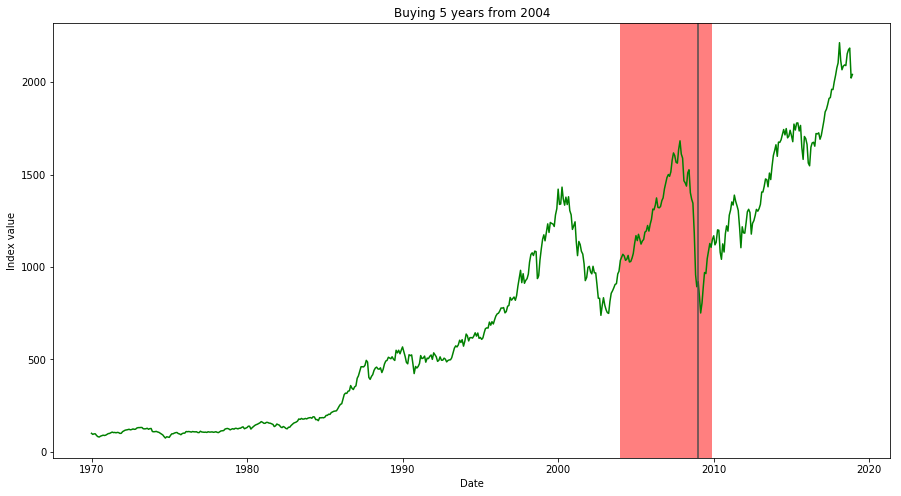

730850
1826
732676
334


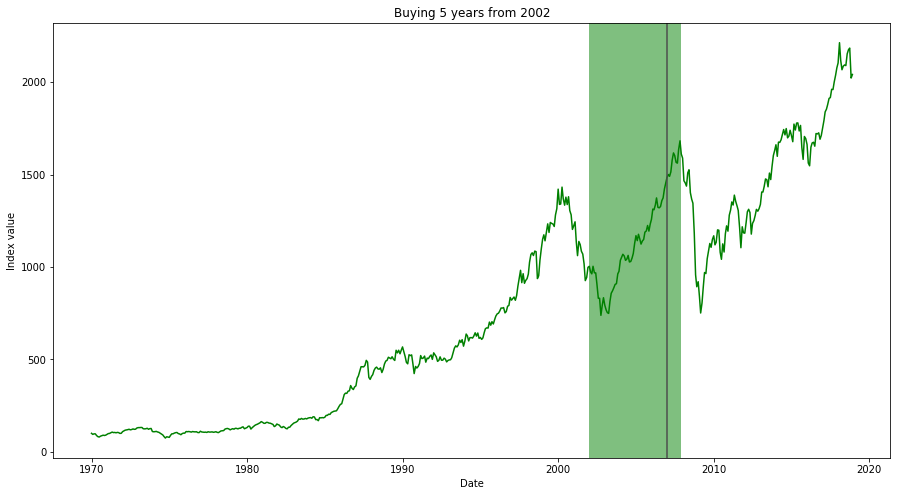

In [204]:
from datetime import date

y_margin = 500
value_max = df_tf["value"].max() + y_margin
value_min = 0 - y_margin/2

#Points of Interest
poi_list = [
    (2004, 5, 'r'),
    (2002, 5, 'g')
] 

for poi in poi_list:
    
    ord_0 = date(1, 1, 1).toordinal()
    
    #Buy dates
    b_min = date(poi[0], 1, 1).toordinal() - ord_0
    b_max = date(poi[0] + poi[1], 1, 1).toordinal() - ord_0
    b_days = b_max - b_min
    print(b_min)
    print(b_days)
    #Sell dates
    s_min = b_max
    s_max = date(poi[0] + poi[1], 12, 1).toordinal() - ord_0
    s_days = s_max - s_min
    print(s_min)
    print(s_days)
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    ax.plot(df_tf["date"], df_tf["value"], color="green")
    plt.title("Buying {} years from {}".format(poi[1], poi[0]))
    plt.ylabel("Index value")
    plt.xlabel("Date")
    
    #Highlight
    highlights = []
    b_rect = Rectangle((b_min, value_min), b_days, value_max)
    s_rect = Rectangle((s_min, value_min), s_days, value_max)
    highlights.append(b_rect)
    highlights.append(s_rect)
    pc = PatchCollection(highlights, facecolor=poi[2], alpha=0.5,
                         edgecolor=None)
    ax.add_collection(pc)
    
    #Add separator between buy and sell
    ax.axvline(b_max,color='0.3', ls='-')
    
    plt.show()
